# Time series statistics
Demonstration and exploration notebook
See also: *Time series statistics* reference poster

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objects as go

from matplotlib import pyplot as plt
from scipy import signal, fft
from astropy import timeseries

while ".toplevel" not in os.listdir():
    os.chdir("..")

plt.rcParams.update({"font.size": 14})


## Time series
Magnetic field interval from PSP

In [2]:
df = pd.read_pickle("data/processed/psp/psp_fld_l2_mag_rtn_201811.pkl")
x_df = df.loc[:, "B_R"][:10000]

if x_df.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{x_df.isnull().sum()} missing points")
print("Length of interval: " + str(x_df.notnull().sum()))
print("Duration of interval: " + str(x_df.index[-1] - x_df.index[0]))
x = x_df.values


No missing data
Length of interval: 10000
Duration of interval: 0 days 00:02:16.519881728


In [3]:
# Frequency of measurements
print("Duration between some adjacent data points:")
print(x_df.index[2] - x_df.index[1])
print(x_df.index[3] - x_df.index[2])
print(x_df.index[4] - x_df.index[3])

a = x_df.index[2] - x_df.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.2f} Hz (2dp)".format(x_freq))


Duration between some adjacent data points:
0 days 00:00:00.013653376
0 days 00:00:00.013653248
0 days 00:00:00.013653248

Frequency is 73.24 Hz (2dp)


Text(0.5, 1.0, '140s of $B_R$ from PSP')

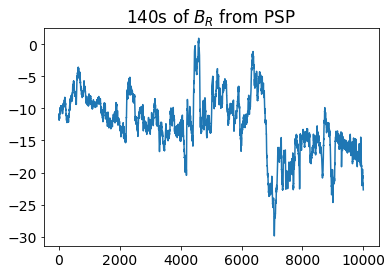

In [4]:
plt.plot(x)
plt.title("140s of $B_R$ from PSP")


Mean = $E(X) = \langle x \rangle = \bar{x} = \int_{-\infty}^{\infty} x\cdot p(X=x)$

In [5]:
print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}".format(np.std(x)))


Mean = -12.4821502587609
Standard deviation = 4.665649531350721


### Demo of removing and interpolating gaps

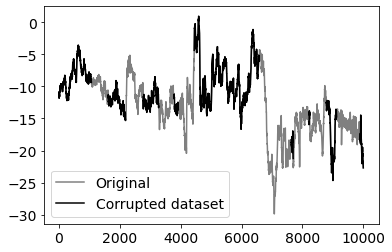

In [6]:
import ts_dashboard_utils
import importlib

importlib.reload(ts_dashboard_utils)

# Removing 50% of data in about 10 chunks
x_bad, x_bad_ind, prop_removed = ts_dashboard_utils.remove_data(x, 0.5, 10)
plt.plot(x, c="grey", label="Original")
plt.plot(x_bad, c="black", label="Corrupted dataset")
plt.legend()
plt.show()


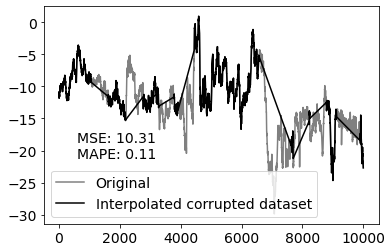

In [7]:
x_bad_adjacent = x_bad[pd.notna(x_bad)]
x_bad_interp = np.interp(np.arange(len(x)), x_bad_ind, x_bad_adjacent)

mse = ts_dashboard_utils.calc_mse(x, x_bad_interp)
mape = ts_dashboard_utils.calc_mape(x, x_bad_interp)

plt.plot(x, c="grey", label="Original")
plt.plot(x_bad_interp, c="black", label="Interpolated corrupted dataset")
plt.text(
    0.1,
    0.3,
    "MSE: {0:.2f}\nMAPE: {1:.2f}".format(mse, mape),
    transform=plt.gca().transAxes,
)
plt.legend()
plt.show()


### PDF

<AxesSubplot:xlabel='B_R', ylabel='Density'>

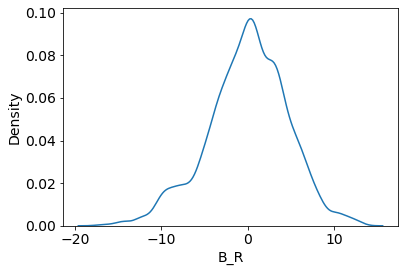

In [8]:
sns.kdeplot(x_df - np.mean(x_df))

### Stationarity assumption
As noted by Matthaeus & Goldstein (1982a), solar wind research normally *assumes, implicitly or explicitly, that the medium being studied is either time stationary or spatially homogenous (or both).* In other words, *that the underlying probability distribution function that describes the observed magnetic fluctuations is invariant with respect to time and/or space.*

This paper finds that *data intervals that span many solar rotations are found to satisfy the conditions of 'weak' stationarity if the effects of solar rotation are included in the asymptotic analysis. Shorter intervals, which include a small integral number of interplanetary sectors, also satisfy weak stationarity.*

**See also more recent work by JagarlamudiEA (2019, looking at ACFs) and KiyaniEA (2009, looking at SFs).**

## Structure functions
Statistical moments of increments. 

*The structure function provides a complementary description to that of the power spectrum. It provides more points on the larger spatial scales, while the power spectrum provides more points on the smaller spatial scales.* (Besserglik & Goldman, 2021)

$$D_p(\tau)=\langle | x(t+\tau)-x(t))^p | \rangle$$

In [9]:
from calc_scales_stats import structure

plt.rcParams.update({"font.size": 14})
# This is an adapted version of Tulasi's `structure(ax, ay, az)`
# from *TurbAn\Analysis\TimeSeries\DataAnalysisRoutines.py*

# See also  `strfn(vecs)` from *ICM-XR-SZ\turb_calc\structure_functions.py*.
# This code is probably the fastest. It works by identifying the indices
# bounding the two sub-arrays (cubes), which we then just subtract from
# each other to calculate the sfn. This is done for logarithmically spaced lags


Let's first take a look at an example of a lagged series, raised to the power 2

<AxesSubplot:xlabel='Time'>

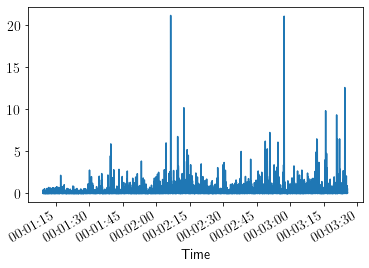

In [10]:
lag_4_squared = x_df.diff(4).pow(2)
lag_4_squared.plot()


In [11]:
lag_4_squared.mean()

0.3621065714820269

In [12]:
sfn = structure(pd.DataFrame(x_df), np.arange(1, 0.2 * len(x_df)), [2, 3, 4])
sfn


2           3            4
1.0      0.049813    0.022261     0.014353
2.0      0.131406    0.100310     0.114723
3.0      0.240221    0.247276     0.378676
4.0      0.362107    0.456094     0.850276
5.0      0.491228    0.720668     1.561280
...           ...         ...          ...
1995.0  41.420843  437.170888  5405.142946
1996.0  41.430371  437.261114  5408.420872
1997.0  41.439898  437.338319  5411.486356
1998.0  41.448302  437.412110  5414.765278
1999.0  41.456979  437.499633  5418.578510

[1999 rows x 3 columns]

We can see that the value of the 2nd order sfn for lag 4 is indeed the mean square of the PDF of the differences of lag 4.
Now, we can plot the entire structure function against the classic 2/3 power-law predicted by theory.

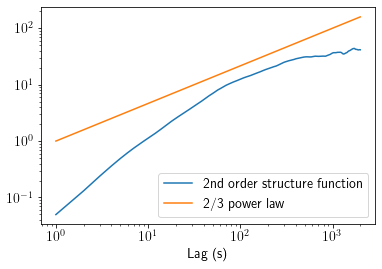

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sfn["2"])
ax.plot(
    np.arange(start=1, stop=sfn.index[-1]),
    np.arange(start=1, stop=sfn.index[-1]) ** (2 / 3),
)
ax.semilogx()
ax.semilogy()
ax.set(title="", xlabel="Lag (s)")
plt.legend(["2nd order structure function", "2/3 power law"])
plt.show()


Skip ahead if you want to see further statistics such as the autocorrelation, skewness, and kurtosis.
Here, I conduct investigation into the uncertainty of the structure function and how it responds to missing data.

First, I produce an extended version of the `structure()` function, that outputs not only the values of the structure function at each lag, but also the consitutent increments used to calculate it, along with the number of points available $N$ and the standard deviation of the distribution.

In [14]:
# Comprehensive fn for investigating sfn


def structure_pre_mean(data, ar_lags, ar_powers):
    """
    Routine to compute the increments of a time series and then the mean (structure function) and standard deviation
    of the PDF of these increments, raised to the specified powers.
    Input:
            data: pd.DataFrame of data to be analysed. Must have shape (1, N) or (3, N)
            ar_lags: The array consisting of lags, being the number of points to shift each of the series
            ar_powers: The array consisting of the Structure orders to perform on the series for all lags
    Output:
            df: The DataFrame containing  corresponding to ar_lags for each order in ar_powers
    """
    # run through ar_lags and ar_powers so that for each power, run through each lag
    df = {}

    if data.shape[1] == 1:
        ax = data.iloc[:, 0].copy()
        for i in ar_powers:
            array = []
            mean_array = []
            std_array = []
            N_array = []
            for lag in ar_lags:
                lag = int(lag)
                dax = np.abs(ax.shift(-lag) - ax)
                strct = dax.pow(i)
                array += [strct.values]

                strct_mean = strct.mean()
                mean_array += [strct_mean]
                strct_std = strct.std()
                std_array += [strct_std]

                N = dax.notnull().sum()
                N_array += [N]

            df["N"] = N_array
            df[str(i)] = array
            df[str(i) + "_mean"] = mean_array
            df[str(i) + "_std"] = std_array
            df[str(i) + "_std_err"] = np.array(std_array) / np.sqrt(N_array)

    else:
        raise ValueError(
            "This version only accepts scalar series: data must be a pd.DataFrame of shape (1, N)"
        )

    df = pd.DataFrame(df, index=ar_lags)
    prop_removed = np.isnan(ax).sum() / len(ax)
    df["missing"] = prop_removed
    return df


Working with a subset of the full series and defining the set of lags to use (usually logarithmically spaced and up to only about 20% of interval length)

In [15]:
ts_clean = x_df[:1000]
del x_df
vals = np.logspace(0, 3, 200)
# lags = np.unique(vals.astype(int))
lags = np.arange(1, 1000)
# Limiting to lags less than half the length of the data
# lags = lags[lags < 0.5 * len(ts)]

sfn = structure(pd.DataFrame(ts_clean), lags, [2, 3, 4])
sfn


2          3          4
1    0.036952   0.014231   0.007420
2    0.053275   0.019977   0.008886
3    0.094069   0.046854   0.027724
4    0.133603   0.079122   0.056762
5    0.177901   0.121745   0.102462
..        ...        ...        ...
995  8.496493  24.803808  72.481596
996  8.325462  24.125501  70.101250
997  8.246808  23.759918  68.603875
998  7.906355  22.284588  62.910000
999  8.434575  24.495978  71.142051

[999 rows x 3 columns]

Producing a function which also extracting the raw increments and calculating confidence regions $\pm SE(\mu)$ for later plotting

In [16]:
def calc_sfn_pm(dataset, lags, powers):
    sfn_pm = structure_pre_mean(pd.DataFrame(dataset), lags, powers)
    lag_vals_wide = pd.DataFrame(sfn_pm["2"].tolist(), index=sfn_pm.index)
    lag_vals_wide.reset_index(inplace=True)  # Make the index a column
    lag_vals_wide.rename(columns={"index": "lag"}, inplace=True)
    lag_vals = pd.melt(
        lag_vals_wide, id_vars=["lag"], var_name="index", value_name="delta^2"
    )
    # Construct error bars
    sfn_pm["2_lower"] = sfn_pm["2_mean"] - 5 * sfn_pm["2_std_err"]
    sfn_pm["2_upper"] = sfn_pm["2_mean"] + 5 * sfn_pm["2_std_err"]
    # If 2_lower is less than 0, set to 0.01
    sfn_pm.loc[sfn_pm["2_lower"] < 0, "2_lower"] = 0.01

    return sfn_pm, lag_vals


In [17]:
# Verify 2_mean is the same as the column 2 in the original sfn calculation above
sfn_pm, lag_vals = calc_sfn_pm(pd.DataFrame(ts_clean), lags, [2, 4])
sfn_pm


N                                                  2    2_mean  \
1    999  [0.042911312783871836, 0.11814242700438626, 0....  0.036952   
2    998  [0.018650837595487246, 0.023741942423839646, 9...  0.053275   
3    997  [0.0028160272777313367, 0.1116749162256383, 0....  0.094069   
4    996  [0.016135988702444592, 0.18676011904972256, 0....  0.133603   
5    995  [0.05062817578527756, 0.3687470307786498, 0.14...  0.177901   
..   ...                                                ...       ...   
995    5  [8.49863705626285, 7.6438188535721565, 8.92032...  8.496493   
996    4  [8.832166854591378, 6.985300953100705, 9.35522...  8.325462   
997    3  [8.12319799015313, 7.370749418681953, 9.246476...  8.246808   
998    2  [8.53845143867602, 7.274259261438601, nan, nan...  7.906355   
999    1  [8.434574734656053, nan, nan, nan, nan, nan, n...  8.434575   

        2_std  2_std_err                                                  4  \
1    0.077848   0.002463  [0.0018413807648352824, 0.013957633058486737, ...   
2    0.077806   0.002463  [0.00034785374301324047, 0.0005636798300569167...   
3    0.137455   0.004353  [7.930009628926962e-06, 0.012471286914003333, ...   
4    0.197361   0.006254  [0.00026037013140541953, 0.03487934206746655, ...   
5    0.266241   0.008440  [0.0025632121833449656, 0.1359743727080705, 0....   
..        ...        ...                                                ...   
995  0.603332   0.269818  [72.2268318140841, 58.42796666622516, 79.57211...   
996  1.024976   0.512488  [78.00717134734256, 48.794429405389614, 87.520...   
997  0.943953   0.544992  [65.98634558722786, 54.32794699300035, 85.4973...   
998  0.893919   0.632096  [72.90515297062859, 52.91484780262527, nan, na...   
999       NaN        NaN  [71.14205095449823, nan, nan, nan, nan, nan, n...   

        4_mean      4_std  4_std_err  missing   2_lower    2_upper  
1     0.007420   0.050098   0.001585      0.0  0.024637   0.049267  
2     0.008886   0.029372   0.000930      0.0  0.040960   0.065589  
3     0.027724   0.093889   0.002973      0.0  0.072303   0.115835  
4     0.056762   0.236190   0.007484      0.0  0.102335   0.164871  
5     0.102462   0.462116   0.014650      0.0  0.135699   0.220103  
..         ...        ...        ...      ...       ...        ...  
995  72.481596  10.160786   4.544042      0.0  7.147402   9.845583  
996  70.101250  16.693800   8.346900      0.0  5.763023  10.887901  
997  68.603875  15.748691   9.092511      0.0  5.521850  10.971767  
998  62.910000  14.135280   9.995153      0.0  4.745875  11.066836  
999  71.142051        NaN        NaN      0.0       NaN        NaN  

[999 rows x 12 columns]

Visualising the distribution of increments at each lag, and how the densities relate to the final structure function (which is simply the mean of the distribution at each lag)

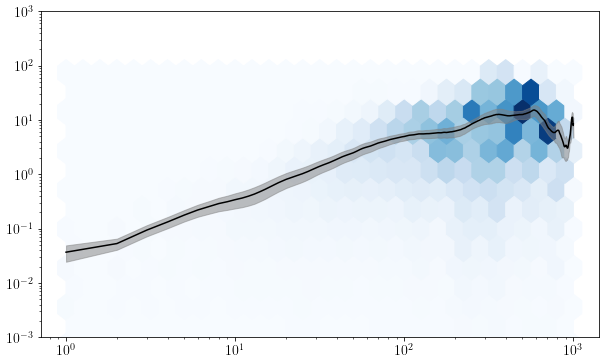

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

# Log inputs first to verify visualisation

plt.hexbin(
    lag_vals["lag"],
    lag_vals["delta^2"],
    gridsize=30,
    cmap="Blues",
    xscale="log",
    yscale="log",
)
plt.ylim(1e-3, 1e3)
plt.plot(sfn["2"], color="black")
plt.fill_between(
    sfn_pm.index, sfn_pm["2_upper"], sfn_pm["2_lower"], color="grey", alpha=0.5
)


Great. Now I will visualise it as a scatter plot, and also overlay some "bad" structure function calculated after removing some of the data from the input time series.
To streamline this, I will create another parent function, which calculates the pre_mean sfn for gapped and interpolated versions of the series for a specified amount of missing data.

In [19]:
from ts_dashboard_utils import calc_mape, calc_mse

plt.rcParams.update({"font.size": 14})


def sfn_master_fn(ts, lags, powers=[2], remove=0, how=None):
    # Remove data as specified
    ts_bad, ts_bad_ind, prop_removed = ts_dashboard_utils.remove_data(ts, remove, how)
    print(f"Removed {prop_removed*100}%")
    # Interpolate the missing data
    ts_adjacent = ts_bad[pd.notna(ts_bad)]
    ts_bad_i = np.interp(np.arange(len(ts)), ts_bad_ind, ts_adjacent)

    sfn_pm, lag_vals = calc_sfn_pm(ts, lags, powers)

    sfn_pm_bad, lag_vals_bad = calc_sfn_pm(ts_bad, lags, powers)
    sfn_pm_bad["lag_error"] = sfn_pm_bad["2_mean"] - sfn_pm["2_mean"]
    sfn_pm_bad["lag_error"] = sfn_pm_bad["2_mean"] - sfn_pm["2_mean"]
    sfn_pm_bad["lag_error_percent"] = sfn_pm_bad["lag_error"] / sfn_pm["2_mean"] * 100

    error_bad = [
        calc_mse(sfn_pm["2_mean"], sfn_pm_bad["2_mean"]),
        calc_mape(sfn_pm["2_mean"], sfn_pm_bad["2_mean"]),
    ]

    sfn_pm_bad_i, lag_vals_bad_i = calc_sfn_pm(ts_bad_i, lags, powers)
    sfn_pm_bad_i["lag_error"] = sfn_pm_bad_i["2_mean"] - sfn_pm["2_mean"]
    sfn_pm_bad_i["lag_error_percent"] = (
        sfn_pm_bad_i["lag_error"] / sfn_pm["2_mean"] * 100
    )
    error_bad_i = [
        calc_mse(sfn_pm["2_mean"], sfn_pm_bad_i["2_mean"]),
        calc_mape(sfn_pm["2_mean"], sfn_pm_bad_i["2_mean"]),
    ]

    # Interpolated version will not recognise missing %: take from missing version
    sfn_pm_bad_i["missing"] = prop_removed

    return (
        ts_bad,
        sfn_pm_bad,
        lag_vals_bad,
        error_bad,
        ts_bad_i,
        sfn_pm_bad_i,
        lag_vals_bad_i,
        error_bad_i,
    )


In [20]:
how = None

(
    ts_clean,
    sfn_pm_clean,
    lag_vals_clean,
    error_clean,
    ts_clean,
    sfn_pm_clean,
    lag_vals_clean,
    error_clean,
) = sfn_master_fn(ts_clean, lags, [2], 0, how)

(
    ts_bad_1,
    sfn_pm_bad_1,
    lag_vals_bad_1,
    error_bad_1,
    ts_bad_1_i,
    sfn_pm_bad_1_i,
    lag_vals_bad_1_i,
    error_bad_1_i,
) = sfn_master_fn(ts_clean, lags, [2], 0.25, how)

(
    ts_bad_2,
    sfn_pm_bad_2,
    lag_vals_bad_2,
    error_bad_2,
    ts_bad_2_i,
    sfn_pm_bad_2_i,
    lag_vals_bad_2_i,
    error_bad_2_i,
) = sfn_master_fn(ts_clean, lags, [2], 0.5, how)

(
    ts_bad_3,
    sfn_pm_bad_3,
    lag_vals_bad_3,
    error_bad_3,
    ts_bad_3_i,
    sfn_pm_bad_3_i,
    lag_vals_bad_3_i,
    error_bad_3_i,
) = sfn_master_fn(ts_clean, lags, [2], 0.75, how)


Removed 0.0%
Removed 25.0%
Removed 50.0%


Removed 75.0%


In [21]:
sfn_pm_bad_3.head()

N                                                  2    2_mean     2_std  \
1  71  [0.042911312783871836, 0.11814242700438626, na...  0.037616  0.051914   
2  60  [0.018650837595487246, nan, nan, nan, nan, nan...  0.041042  0.055525   
3  61  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  0.093521  0.170327   
4  62  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  0.130784  0.172013   
5  63  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  0.150453  0.199064   

   2_std_err  missing   2_lower   2_upper  lag_error  lag_error_percent  
1   0.006161     0.75  0.006811  0.068422   0.000664           1.797990  
2   0.007168     0.75  0.005200  0.076883  -0.012233         -22.962202  
3   0.021808     0.75  0.010000  0.202561  -0.000548          -0.582213  
4   0.021846     0.75  0.021555  0.240012  -0.002819          -2.110299  
5   0.025080     0.75  0.025055  0.275851  -0.027448         -15.428579

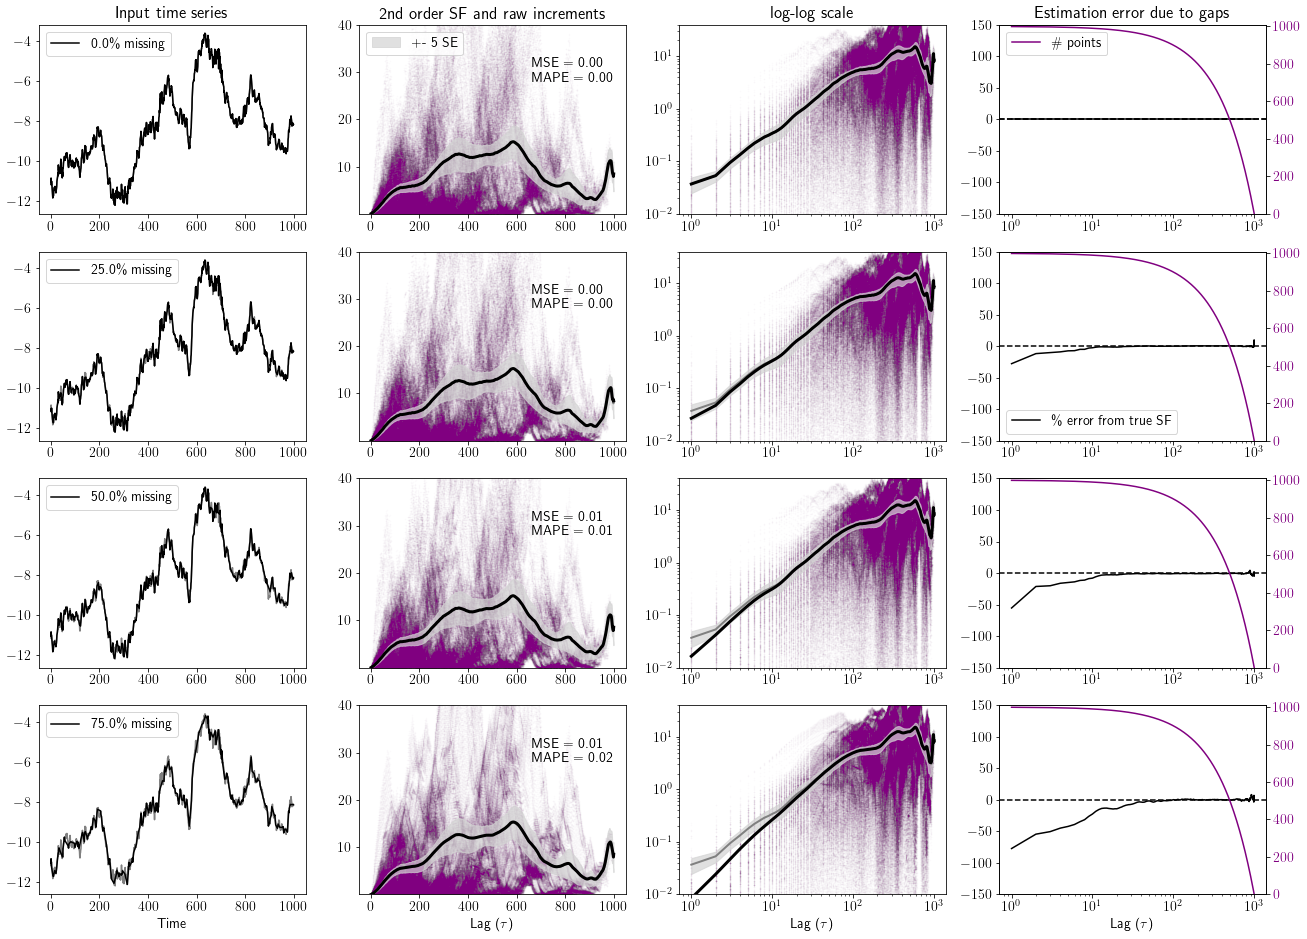

In [29]:
colour = "purple"

fig, ax = plt.subplots(4, 4, figsize=(22, 16))

# Plot input time series in first column
ts_list = [
    ts_clean,
    ts_bad_1_i,
    ts_bad_2_i,
    ts_bad_3_i,
]

lag_val_list = [
    lag_vals_clean,
    lag_vals_bad_1_i,
    lag_vals_bad_2_i,
    lag_vals_bad_3_i,
]

sfn_pm_list = [
    sfn_pm_clean,
    sfn_pm_bad_1_i,
    sfn_pm_bad_2_i,
    sfn_pm_bad_3_i,
]

error_list = [error_clean, error_bad_1_i, error_bad_2_i, error_bad_3_i]  # [mse, mape]

ax[0, 0].set_title("Input time series")
ax[0, 1].set_title("2nd order SF and raw increments")
ax[0, 2].set_title("log-log scale")
ax[0, 3].set_title("Estimation error due to gaps")

for i, vals in enumerate(zip(ts_list, sfn_pm_list, lag_val_list, error_list)):
    ts, sfn_pm, lag_vals, error = vals
    missing = sfn_pm["missing"].values[0]
    # missing = np.isnan(ts_plot).sum() / len(ts_plot)
    ax[i, 0].plot(ts_clean, color="grey")  # Complete time series
    # Below not correct for interpolated dataset (0% missing) but good enough for now:
    ax[i, 0].plot(ts, color="black", label=f"{np.round(missing*100, 2)}\% missing")
    ax[i, 0].legend(loc="upper left")

    ax[i, 1].annotate(
        "MSE = {0:.2f}\nMAPE = {1:.2f}".format(error[0], error[1]),
        xy=(1, 1),
        xycoords="data",
        xytext=(0.65, 0.7),
        textcoords="axes fraction",
        transform=ax[i, 1].transAxes,
        c="black",
    )

    ax[i, 3].plot(
        sfn_pm["lag_error_percent"], color="black", label="\% error from true SF"
    )
    ax[i, 3].semilogx()
    ax[i, 3].set_ylim(-150, 150)
    ax[i, 3].axhline(0, color="black", linestyle="--")

    ax2 = ax[i, 3].twinx()
    ax2.plot(sfn_pm["N"], color=colour, label="\# points")
    ax2.set_ylim(0, 1.01 * len(sfn_pm))
    # Make the y-axis tick labels match the line color
    for tl in ax2.get_yticklabels():
        tl.set_color(colour)

    if i == 0:
        ax2.legend(loc="upper left")

    # Plot scatter plot and line plot for both log-scale and linear-scale
    for j, plot_type in enumerate(["linear", "log"]):
        j += 1

        ax[i, j].plot(sfn_pm_clean["2_mean"], color="grey", linewidth=2)
        ax[i, j].plot(sfn_pm["2_mean"], color="black", linewidth=3)
        ax[i, j].scatter(
            lag_vals["lag"], lag_vals["delta^2"], alpha=0.01, s=1, c=colour
        )

        # Plot "confidence region"
        ax[i, j].fill_between(
            sfn_pm_clean.index,
            sfn_pm_clean["2_lower"],
            sfn_pm_clean["2_upper"],
            color="lightgrey",
            alpha=0.7,
            label="+- 5 SE",
        )

        ax[i, j].set_ylim(1e-2, 40)

    ax[i, 2].semilogx()
    ax[i, 2].semilogy()

ax[3, 0].set_xlabel("Time")
for i in range(1, 4):
    ax[3, i].set_xlabel("Lag ($\\tau$)")

ax[0, 3].axhline(0, color="black", linestyle="--")
ax[0, 3].semilogx()

ax[1, 3].legend(loc="lower left")
ax[0, 1].legend(loc="upper left")
plt.show()


- Run for two sets of chunks and one set of uniform, save plots (shuld be 6 total)
- Commit (if changes)
- Write-up
- Think about looping over various values of % missing, and how to manage this data and visualise it (practise below)

In [23]:
sfn_pm_bad_all = None
sfn_pm_bad_all_i = None

for i, remove in enumerate([0.1, 0.25, 0.5, 0.75, 0.9]):
    for i in range(10):
        (
            ts_bad,
            sfn_pm_bad,
            lag_vals_bad,
            error_bad,
            ts_bad_i,
            sfn_pm_bad_i,
            lag_vals_bad_i,
            error_bad_i,
        ) = sfn_master_fn(ts_clean, lags, [2], remove, 5)

        # Concatenate each successive sfn_pm_bad_i to the previous one
        if sfn_pm_bad_all is None:
            sfn_pm_bad_all = sfn_pm_bad
            sfn_pm_bad_all_i = sfn_pm_bad_i
        else:
            sfn_pm_bad_all = pd.concat([sfn_pm_bad_all, sfn_pm_bad], axis=0)
            sfn_pm_bad_all_i = pd.concat([sfn_pm_bad_all_i, sfn_pm_bad_i], axis=0)

sfn_pm_bad_all.reset_index(inplace=True)
sfn_pm_bad_all.rename(columns={"index": "lag"}, inplace=True)
lag_error_percent_mean = sfn_pm_bad_all.groupby("lag")["lag_error_percent"].mean()


sfn_pm_bad_all_i.reset_index(inplace=True)
sfn_pm_bad_all_i.rename(columns={"index": "lag"}, inplace=True)
lag_error_percent_mean_i = sfn_pm_bad_all_i.groupby("lag")["lag_error_percent"].mean()


Removed 11.200000000000001%


Removed 10.299999999999999%
Removed 11.600000000000001%
Removed 10.2%
Removed 10.299999999999999%
Removed 11.4%
Removed 11.1%
Removed 10.2%
Removed 11.899999999999999%
Removed 10.5%
Removed 26.1%
Removed 29.099999999999998%
Removed 27.0%
Removed 28.4%
Removed 28.199999999999996%
Removed 25.7%
Removed 28.4%
Removed 26.0%
Removed 27.800000000000004%
Removed 26.900000000000002%
Removed 51.4%
Removed 51.6%
Removed 51.300000000000004%
Removed 53.1%
Removed 58.699999999999996%
Removed 52.800000000000004%
Removed 52.900000000000006%
Removed 50.2%
Removed 56.00000000000001%
Removed 55.900000000000006%
Removed 78.10000000000001%
Removed 83.5%
Removed 79.7%
Removed 75.3%
Removed 75.1%
Removed 76.3%
Removed 78.7%
Removed 79.80000000000001%
Removed 76.6%
Removed 76.3%
Removed 90.2%
Removed 94.8%
Removed 94.8%
Removed 94.1%
Removed 90.5%
Removed 97.6%
Removed 91.7%
Removed 93.30000000000001%
Removed 93.0%
Removed 93.0%


Text(0, 0.5, '\\% error')

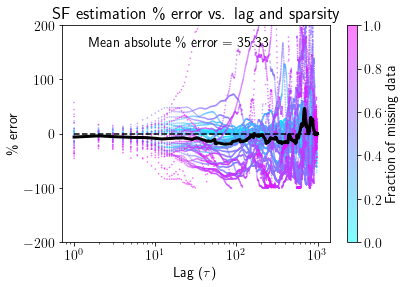

In [32]:
plt.title("SF estimation \% error vs. lag and sparsity")
plt.plot(lag_error_percent_mean, color="black", lw=3)
plt.scatter(
    sfn_pm_bad_all["lag"],
    sfn_pm_bad_all["lag_error_percent"],
    c=sfn_pm_bad_all["missing"],
    s=0.5,
    alpha=0.5,
    cmap="cool",
)

plt.annotate(
    "Mean absolute \% error = {0:.2f}".format(
        sfn_pm_bad_all["lag_error_percent"].abs().mean()
    ),
    xy=(1, 1),
    xycoords="axes fraction",
    xytext=(0.1, 0.9),
    textcoords="axes fraction",
    c="black",
)

cb = plt.colorbar()
cb.set_label("Fraction of missing data")
# Change range of color bar
plt.hlines(0, 1, 1000, color="black", linestyle="--")
plt.clim(0, 1)
plt.ylim(-200, 200)
plt.semilogx()
plt.xlabel("Lag ($\\tau$)")
plt.ylabel("\% error")
# Annotate with mean absolute value


---

### Skewness
Normalised 3rd moment of increments: asymmetry of a distribution about the mean, = 0 for a normal distribution

$$S=\frac{\mu_3}{\sigma^3}=\frac{D_3(\tau)}{D_2(\tau)^{3/2}}

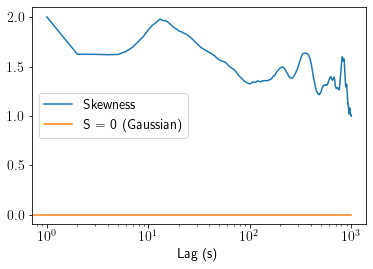

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sfn["3"] / (sfn["2"] ** (3 / 2)))
ax.plot(np.repeat(0, len(sfn)))
ax.semilogx()
ax.set(title="", xlabel="Lag (s)")
plt.legend(["Skewness", "S = 0 (Gaussian)"])
plt.show()


Has a very similar (but not identical) shape to the kurtosis, below.

#### Un-normalised third moment

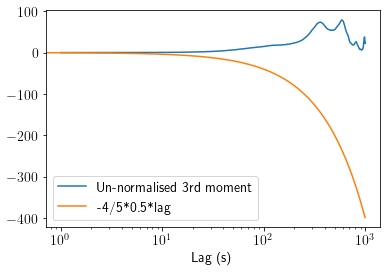

In [26]:
epsilon = 0.5  # Dissipation rate (have simply chosen number that results in best fit of data to theoretical shape)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sfn["3"])  # /(sfn["2"]**(3/2))
ax.plot(np.arange(len(sfn)), (-4 / 5) * epsilon * np.arange(len(sfn)))  # -4/5 law??
ax.semilogx()
ax.set(title="", xlabel="Lag (s)")
plt.legend(["Un-normalised 3rd moment", "-4/5*{}*lag".format(epsilon)])
plt.show()


### Kurtosis
Normalised 4th moment of increments: fatness of the tails, i.e. propensity for extreme values, = 3 for a normal distribution

$$\kappa=\frac{\mu_4}{\sigma^4}=\frac{D_4(\tau)}{D_2(\tau)^{2}}

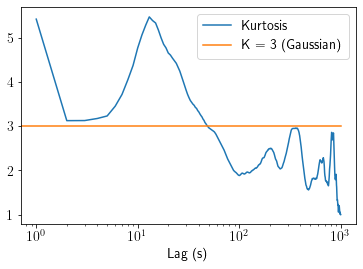

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sfn["4"] / (sfn["2"] ** (4 / 2)))
ax.plot(np.arange(len(sfn)), np.repeat(3, len(sfn)))
ax.semilogx()
ax.set(title="", xlabel="Lag (s)")
plt.legend(["Kurtosis", "K = 3 (Gaussian)"])
plt.show()


## Autocorrelation function

$$R(\tau)=\langle x(t+\tau)x(t) \rangle$$

The autocorrelation function and structure function are functions of *lag* $\tau$. These lags can be converted to time or length units with the following operations, where $f$ = sampling frequency and $v$ = flow velocity.

$t=\tau \times f$

$l=t \times v$

This latter equation results from Taylor's *frozen-in flow hyptothesis*, which allows for the interpretation of temporal lags as spatial lags.

For a first-order process the theoretical acf decreases exponentially and the sample function should have a similar shape (Chatfield, 1980).

In [28]:
acovf = sm.tsa.acovf(x, nlag=9999)  # See whether this affects BT-method
# This uses the following code (if fft = False):
# xo = x - x.mean()
# acov = np.correlate(xo, xo, "full")[n - 1 :] / d[n - 1 :]

acf = acovf / acovf[0]  # same as sm.tsa.acf(x)


# By default, acovf() and acf() use the FFT, which is recommended for long time series

sfn = structure(x_df, [2], 1, 0.9999)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(acf, "g-")
ax2.plot(sfn["2"], "b-")

ax1.set_xlabel("Lag")
ax1.set_ylabel("Autocorrelation", color="g")
ax2.set_ylabel("2nd-order structure function", color="b")


NameError: name 'x_df' is not defined

Note the clear inverse relationship between the second-order sfn and the ACF. We can produce one from the other, which is what Chuychai *et al.* (2018) do to then calculate the Taylor scale, as discussed below.

$$R(\tau)=1-\frac{D_2(\tau)}{2\langle x(t)^2\rangle}$$

In [ ]:
acf_from_sfn = 1 - sfn["2"] / (2 * acovf[0])

# plt.plot(acf, color='g')
# plt.plot(acf_from_sfn, color='b')
# plt.legend(["ACF", "ACF from second-order sfn"])
# plt.title("Autocorrelation")

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(acf)), y=acf, name="ACF"))
fig.add_trace(
    go.Scatter(x=np.arange(len(acf)), y=acf_from_sfn, name="ACF from 2nd-order sfn")
)

# fig.update_xaxes(type="log", title_text="Frequency (Hz)")
# fig.update_yaxes(type="log", title_text='PSD [nT^2/Hz]') # Cannot get Latex to render
fig.update_layout(
    legend_title_text="Method", width=700, height=450, title_text="Autocorrelation"
)
fig.show()


The discrepancy between two functions above lag ~ 6000 likely results from discontinuity in time series after t ~ 6000. This violates the assumption of stationarity in the equation above: $$\langle x(t)\rangle=\langle x(t+\tau)\rangle$$

**See Panchev pg69, Fig.17 and below for discussion on why one might want to use the structure function instead of the ACF**

The ACF is useful for turbulence analysis as we can use it to calculate two important scales at either end of the inertial range: the **integral length scale** and **Taylor microscale**. For more on this analysis, see the reynolds-scales project.

### Partial autocorrelation function

See 4.2.2 of Chatfield (pg 69); 2.2.3 of Fan & Yao (pg 43) 

- `statsmodels` uses `pacf(method="ywadjusted")`, which uses 
- `pacf_yw(method="adjusted")`, which uses 
- `yule_walker(x, k, method="adjusted")`, which performs linear algebra

## Power spectrum
Talk to Mark about this. Work through scipy documentation: https://docs.scipy.org/doc/scipy/reference/signal.html#spectral-analysis

See Matthaeus & Goldstein (1982b) for comments on Blackman-Tukey method in context of solar wind analysis.

### Fourier transform
Work through the scipy documentation https://docs.scipy.org/doc/scipy/tutorial/fft.html

In [ ]:
x[0:5]

array([-11.06131458, -10.85416412, -11.19788265, -11.00824833,
       -11.18834209])

In [ ]:
ft_x = fft.fft(x, norm="backward")  # Normalisation of 1/n only on the backward term
ft_x[0:5]


array([-124821.50258761    -0.j        ,   -6463.35991464-12560.39950741j,
          9982.76137474-11956.29300279j,   -3189.59329713 +2297.68864154j,
         -3891.0307961  -6037.97316072j])

In [ ]:
np.sum(x)

-124821.502587609

Note that the first term is equal to the sum of the series.

In [ ]:
ft_x_inv = fft.ifft(ft_x, norm="backward")
ft_x_inv[0:5]


array([-11.06131458-8.52651283e-17j, -10.85416412+9.27613542e-16j,
       -11.19788265+1.31592515e-15j, -11.00824833+1.65397108e-15j,
       -11.18834209+1.30739863e-16j])

Verified that inverse of fft is the original series (treating very small imaginary components as 0).

In [ ]:
def _next_regular(target):
    """
    Find the next regular number greater than or equal to target.
    Regular numbers are composites of the prime factors 2, 3, and 5.
    Also known as 5-smooth numbers or Hamming numbers, these are the optimal
    size for inputs to FFTPACK.

    Target must be a positive integer.
    """
    if target <= 6:
        return target

    # Quickly check if it's already a power of 2
    if not (target & (target - 1)):
        return target

    match = float("inf")  # Anything found will be smaller
    p5 = 1
    while p5 < target:
        p35 = p5
        while p35 < target:
            # Ceiling integer division, avoiding conversion to float
            # (quotient = ceil(target / p35))
            quotient = -(-target // p35)
            # Quickly find next power of 2 >= quotient
            p2 = 2 ** ((quotient - 1).bit_length())

            N = p2 * p35
            if N == target:
                return N
            elif N < match:
                match = N
            p35 *= 3
            if p35 == target:
                return p35
        if p35 < match:
            match = p35
        p5 *= 5
        if p5 == target:
            return p5
    if p5 < match:
        match = p5
    return match


##### Power spectra using different methods

In [ ]:
# Number of sample points
N = len(x)

# Sample spacing
T = 1 / x_freq

freqs = fft.fftfreq(N, T)
# This gives us the full set of sample frequencies for the Discrete Fourier Transform.
# There are both positive and negative frequencies, but the function is symmetric, so we can just take the first (positive)
# half as our values for the x-axis of the power spectrum

# x-axis values (length N/2)
freqs_positive = fft.fftfreq(N, T)[: N // 2]

# To get the y-values, we similarly need to select the values of the Fourier transform for the positive frequencies.
# We can also use fft.rfft(x) for this, noting that this array is of length (N/2)+1 rather than N/2

power_ft = 1.0 / N * np.abs(ft_x[0 : (N // 2)]) ** 2

# FFT with windowing method to prevent spectral leakage by enforcing periodicity on an aperiodic signal
# boxcar = rectangular window = no window
w = signal.windows.boxcar(N)
ft_x_w = fft.fft(x * w)
power_ft_w = 1.0 / N * np.abs(ft_x_w[0 : (N // 2)]) ** 2

# The power spectrum can be estimated directly, with the option of a window, using periodogram()

f_periodogram, power_periodogram = signal.periodogram(
    x, fs=x_freq, window="boxcar", scaling="density"
)
power_periodogram = (x_freq / 2) * power_periodogram  # Correcting scaling

# You can create smoother spectra by additionally averaging across (possibly overlapping) segments
# with welch(). This method reduces noise at the expense of reducing the frequency resolution

f_welch, power_welch = signal.welch(
    x, fs=x_freq, window="boxcar", scaling="density", nperseg=len(x)
)
power_welch = (x_freq / 2) * power_welch  # Correcting scaling
# Set nperseg=len(x) to get identical spectrum to periodogram() (only one segment)
# Set noverlap=0 and window = "boxcar" to get Bartlett's method (averaging but no overlap or windowing)

# Note scaling for both of the methods above, shown inside _spectral_helper():
## if scaling = 'density' (and mode = 'psd', default), the result is multiplied by 2.0 / (fs * (win*win).sum())

# PSD estimation using Lomb-Scargle method (typically used for incomplete signals)
# See here for details: http://jakevdp.github.io/blog/2017/03/30/practical-lomb-scargle/

## Using scipy
freqs_positive_angular = (
    (freqs_positive + 10e-100) * 2 * np.pi
)  # Fixing issue with float division
power_ls_scipy = signal.lombscargle(
    np.arange(N) / x_freq, x, freqs_positive_angular, normalize=False
)

## Using astropy
power_ls_astropy = timeseries.LombScargle(
    np.arange(N) / x_freq, x, normalization="psd"
).power(freqs_positive[1:])


# Using smoothing function from Tulasi
def SmoothySpec(a, nums=None):
    b = a.copy()
    if nums is None:
        nums = 2 * len(b) // 3
    for i in range(nums):
        b[i + 1 : :][:-1] = (
            0.25 * b[i::][:-2] + 0.5 * b[i + 1 : :][:-1] + 0.25 * b[i::][2:]
        )
    return b


power_smooth = SmoothySpec(power_ft)

# Using Fourier transform of autocorrelation function

# (Blackman-Tukey method, utilising Wiener-Khinchin theorem)
# See Matthaeus & Goldstein (1982) for comparison of methods

# Typically this also involves windowing
# w = signal.windows.bartlett(N/5)

# Including negative lags (symmetric function)
full_acovf = np.zeros(2 * 10000)
full_acovf[10000 : 10000 * 2] = acovf
full_acovf[0:10000] = acovf[::-1]

ft_acovf = fft.fft(full_acovf)
power_ft_acovf_real = np.real(ft_acovf)

w_acf = np.pad(
    signal.windows.cosine(len(full_acovf) * 0.1),
    pad_width=int(0.5 * (1 - 0.1) * len(full_acovf)),
)
ft_acovf_window = fft.fft(w_acf * full_acovf)
power_ft_acovf_real_w = np.real(ft_acovf_window)

# This gets us very close. The following steps may get us closer:
# Kkeep +ve values (of BT method), else look at Parseval's theorem
# (Need to include -ve values of psd)
# Pi = np.sum(np.abs(im)**2) # raw data (Mark had np.mean() instead)
# Pf = np.sum(fek) # power spec
# print(n, Pi, Pf, Pi == Pf)


# Equivalent spectrum using second-order structure function (Chhiber et al., 2018)

sfn = calc_sfn(x_df, p=[2], freq=x_freq, max_lag_prop=0.99)  # freq = x_freq
sfn["s2*lag"] = sfn["2"] * sfn["lag"]
freqs_es = 1 / sfn["lag"]
power_es = sfn["s2*lag"]

###########################################################################################

# Interactive plot
# Allows easy comparision of different methods: remove certain lines, zoom in, pan, etc.
# BUGS: Cannot get Latex to render and axis labels are weird

fig = go.Figure()

fig.add_trace(go.Scatter(x=freqs_positive, y=power_ft, name="FT"))
fig.add_trace(
    go.Scatter(x=freqs_positive, y=power_ls_scipy, name="Lomb-Scargle (scipy)")
)
fig.add_trace(
    go.Scatter(x=freqs_positive[1:], y=power_ls_astropy, name="Lomb-Scargle (astropy)")
)
fig.add_trace(go.Scatter(x=freqs_positive, y=power_ft_w, name="FT w. window"))
fig.add_trace(
    go.Scatter(x=freqs_positive[1:], y=power_periodogram[1:], name="Peridogram")
)
# Periodogram method has silly first value that affects plotting, hence indices. If using proper Welch, remove these.
fig.add_trace(go.Scatter(x=f_welch[1:], y=power_welch[1:], name="Welch"))

fig.add_trace(
    go.Scatter(
        x=freqs_positive,
        y=power_ft_acovf_real[power_ft_acovf_real > 0][: len(power_ft)],
        name="Blackman-Tukey",
    )
)
fig.add_trace(
    go.Scatter(
        x=freqs_positive,
        y=power_ft_acovf_real_w[power_ft_acovf_real_w > 0][: len(power_ft)],
        name="Blackman-Tukey w. window",
    )
)

fig.add_trace(go.Scatter(x=freqs_positive, y=power_smooth, name="SmoothySpec"))
fig.add_trace(
    go.Scatter(x=freqs_es, y=power_es, name="Equivalent spectrum")
)  # Note translation of curve to align with true spectra
# fig.add_trace(go.Scatter(x=freqs_positive, y=power_ft_acovf_real, name = "Blackman-Tukey (Real)"))
# fig.add_trace(go.Scatter(x=freqs_positive, y=power_ft_acovf_abs_sqd_norm, name = "Blackman-Tukey (Abs->Sqd->Norm)"))


fig.add_trace(
    go.Scatter(
        x=freqs_positive[1:],
        y=1000 * freqs_positive[1:] ** (-5 / 3),
        name="-5/3 power law",
    )
)

fig.update_xaxes(type="log", title_text="Frequency (Hz)")
fig.update_yaxes(type="log", title_text="PSD [nT^2/Hz]")
fig.update_layout(
    legend_title_text="Method",
    width=700,
    height=450,
    title_text="Power spectrum of scalar PSP interval via different methods",
)
fig.show()


Parseval's theorem. (Can't seem to get it to work for BT method)

In [ ]:
np.round(np.sum(x**2), 5) == np.round(np.sum(1.0 / N * np.abs(ft_x) ** 2), 5)

True

[]

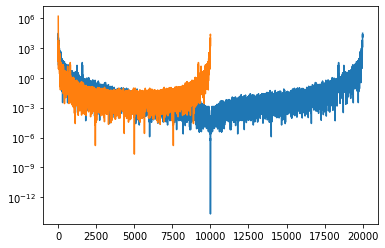

In [ ]:
plt.plot(np.abs(power_ft_acovf_real))
plt.plot(1.0 / N * np.abs(ft_x) ** 2)
plt.semilogy()


### Demonstrating the window functions

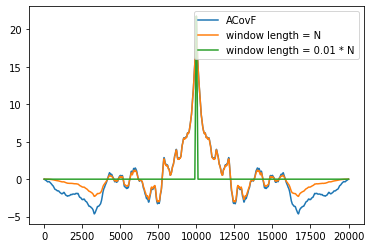

In [ ]:
w_N = signal.windows.cosine(len(full_acovf))
w_001 = np.pad(
    signal.windows.cosine(len(full_acovf) * 0.01),
    pad_width=int(0.5 * (1 - 0.01) * len(full_acovf)),
)

plt.plot(full_acovf, label="ACovF")
plt.plot(w_N * full_acovf, label="window length = N")
plt.plot(w_001 * full_acovf, label="window length = 0.01 * N")
plt.legend()
plt.show()


- The advantage of the BT technique is that the goal that R(r) -> 0 can be checked.
- The advantage of the equivalent spectra is that is much smoother than the power spectrum but still captures all the features. We can also add “true”, single-value structure functions calculated from multi-spacecraft measurements where we don’t need to assume Taylor’s hypothesis.
- **See Mark's notebook for nice diagrams of different windows**

Non-interactive `matplotlib` version

In [ ]:
# plt.semilogy(freqs_positive, 2.0/N * np.abs(ft_x[0:(N//2)])**2)
# plt.semilogy(freqs_positive, 2.0/N * np.abs(ft_x_window[0:(N//2)])**2)
# plt.semilogy(f, 2.0/N * power_periodogram)
# plt.semilogy(freqs_positive, 2.0/N * power_ls_scipy)
# plt.semilogy(f_welch, 2.0/N * power_welch)
# plt.semilogy(freqs_positive, 2.0/N * np.real(ft_acf[0:(N//2)]))
# plt.semilogy(freqs_positive[1:], power_ls_astropy)
# plt.legend(['FFT', 'FFT w. window', 'Periodogram','Lomb-Scargle (scipy)', 'Welch', "FFT of ACF", "Lomb-Scargle (astropy)"])
# plt.semilogx()
# plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD')
# plt.title("Power spectrum for a PSP interval via different methods")
# plt.grid()
# plt.show()




In [ ]:
# plot_acf(x, alpha=None, use_vlines=False, marker = '.', lags=400)

# Statistics in 3D
In 3D, we get statistics such as the ACF and power spectrum from the **trace** of the corresponding **matrix**. For example, the ACF for each vector component $x,y,z$ is given by the *diagonal components* of the ACF matrix: 

$R(\tau)=\text{trace}  R_{ij}(\tau)$

$R_{ij}(\tau)=\langle\delta B_i(t)\delta B_j(t+\tau)\rangle$

For power spectra $E(k)$ in three dimensions, we can use a perpendicular spectrum (see `TurbAn\Analysis\Simulations\AnalysisFunctions.py`), or a 3D spectrum and calculate the modulus (talk to Mark about this)

# Other datasets

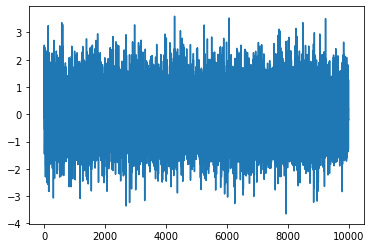

In [ ]:
white_noise = np.random.randn(10000)
plt.plot(white_noise)


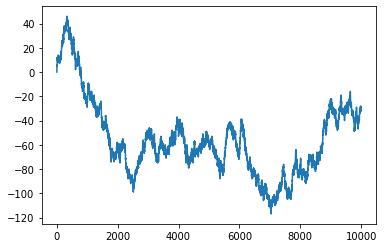

In [ ]:
import random

random.seed(42)


def randomwalk1D(n):
    x, y = 0, 0
    # Generate the time points [1, 2, 3, ... , n]
    timepoints = np.arange(n + 1)
    positions = [y]
    directions = ["UP", "DOWN"]
    for i in range(1, n + 1):
        # Randomly select either UP or DOWN
        step = random.choice(directions)

        # Move the object up or down
        if step == "UP":
            y += 1
        elif step == "DOWN":
            y -= 1
        # Keep track of the positions
        positions.append(y)
    return timepoints, positions


time_data, pos_data = randomwalk1D(10000)
plt.plot(time_data, pos_data)
